# Statistical Shape Modeling

Statistical shape models (SSMs) provide a principled way for extracting knowledge from empirically given collections of objects.
Instead of considering only a few quantities derived from a shape, such as volume, studying shapes in their entirety allows for a full geometric characterization and hence more differentiated assertions about the shapes.
SSMs describe the geometric variability in a collection in terms of a mean shape and a hierarchy of major modes explaining the main trends of shape variation.
Based on a notion of shape space, SSMs can be learned from consistently parametrized instances from the object class under study.
The resulting models provide a shape prior that can be used to constrain synthesis and analysis problems.
Moreover, their parameter space provides a compact representation that is amenable to learning algorithms (e.g. classification or clustering), evaluation, and exploration.

## Intrinsic mean

The simplest - yet also perhaps most fundamentally important - statistic is the sample mean, which estimates the center of a data set.
Because a Riemannian manifold $\mathcal{M}$ has a distance metric $\text{dist}_\mathcal{M}$, we can characterize the mean as the point closest to the data points $x_1,\ldots,x_N \in \mathcal{M}$.
This leads to the notion of (sample) Fréchet mean that is the minimizer of the sum-of-squared geodesic distances to the data:

$$\mu = \arg\min_{x\in\mathcal{M}}  \sum_{i=1}^N \text{dist}_\mathcal{M}^2(x,x_i)$$

While closed-form solutions exist in flat spaces, solving this least-squares problem in general requires iterative optimization routines.
To this end, `morphomatics.stats.ExponentialBarycenter` implements the efficient Newton-type fixed-point iteration

$$ \mu_{k+i} = \exp_{\mu_k} \left( 1/N \sum_{i=1}^N \log_{\mu_k}(x_i) \right). $$

As it requires only a notion of exponential and logarithmic map, it can also be used to compute bi-invariant means in affine connection spaces.

## Principal geodesic analysis

For second order statistics `morphomatics.stats.PrincipalGeodesicAnalysis` provides (linearized) Principal Geodesic Analysis at $\mu$ that is an extension of the common Principal Component Analysis to Riemannian manifolds allowing for covariance analysis.
In particular, the solution is found algorithmically by eigendecomposition of the Gram matrix $C=(c_{ij})_{ij}$, with elements $c_{ij}=g_{\mu}{\left(\log_\mu{(x_i)}, \log_\mu{(x_j)}\right)}$.

## Statistical shape model (SSM)

In order to avoid a systematic bias due to the choice of reference shape (cf. the introduction to [Shape Space](../tutorial_shape_space)), we require it to agree with the mean of the training data.
This approach yields a cyclic dependency between the reference and the mean shape.
In `morphomatics.stats.StatisticalShapeModel` we provide an method to construct a statistical shape model for which the mean agrees with the reference based on an alternating optimization strategy.

Currently SSMs can be build based on three different [Shape Spaces](../tutorial_shape_space): `PointDistributionModel`, `DifferentialCoords` and `FundamentalCoords`.
The illustrative example below details how to set up a `morphomatics.manifold.FundamentalCoords` SSM and explains its basic usage. Other types are constructed analogously replacing the Shape Space accordingly. However,
as Shape Spaces can allow for parameters the following code snippet is showing the default case. Note that faces and vertices need to be organized as explained [here](../tutorial_shape_space).

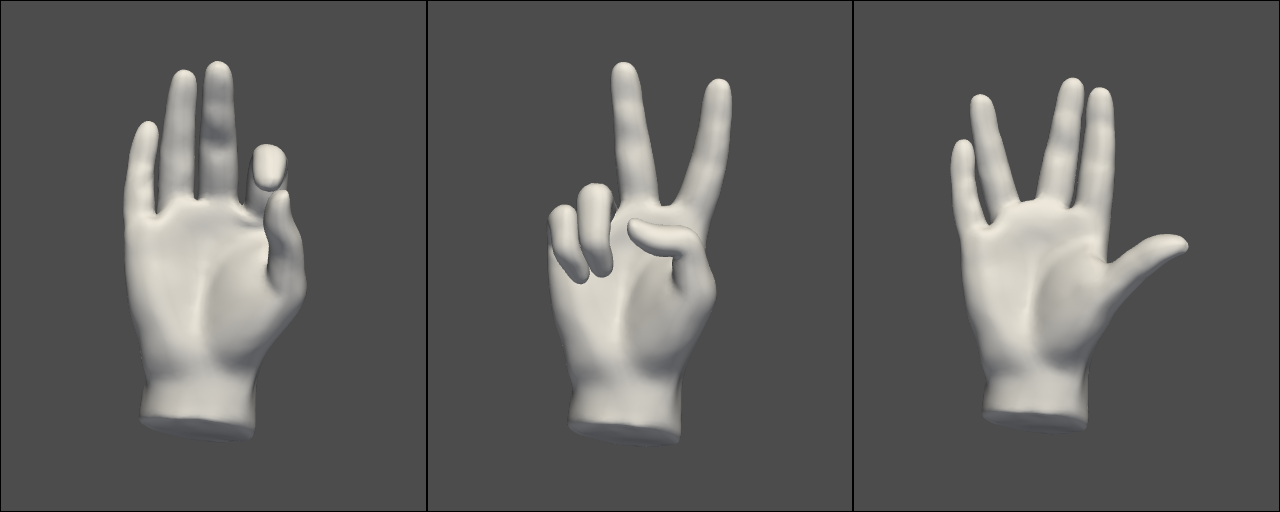

In [4]:
''' Read and show surfaces. '''

import pyvista as pv

# load surfaces
meshes = [pv.read(f'./tutorial2_pop_med_image_shape_ana/data/hand{i}.ply') for i in [1,2,3]]

# show
pl = pv.Plotter(notebook=True, shape=(1,3))
for i in range(3):
    pl.subplot(0, i)
    pl.add_mesh(meshes[i], smooth_shading=True)
    pl.view_yx()
    pl.camera.roll += 180
    pl.camera.zoom(2)
pl.show(jupyter_backend='static', window_size=(1280,512))

In [ ]:
''' Construct SSM. '''

from morphomatics.geom import Surface
from morphomatics.stats import StatisticalShapeModel
from morphomatics.manifold import FundamentalCoords

# to Surface type
as_surface = lambda mesh: Surface(mesh.points, mesh.faces.reshape(-1, 4)[:, 1:])
surfaces = [as_surface(m) for m in meshes]

# construct model
SSM = StatisticalShapeModel(lambda ref: FundamentalCoords(ref))
SSM.construct(surfaces)


Having set up the model one can easily access the mean shape vertex coordinates (`SSM.mean.v`),
as well as the mean coordinates in Shape Space (`SSM.mean_coords`).

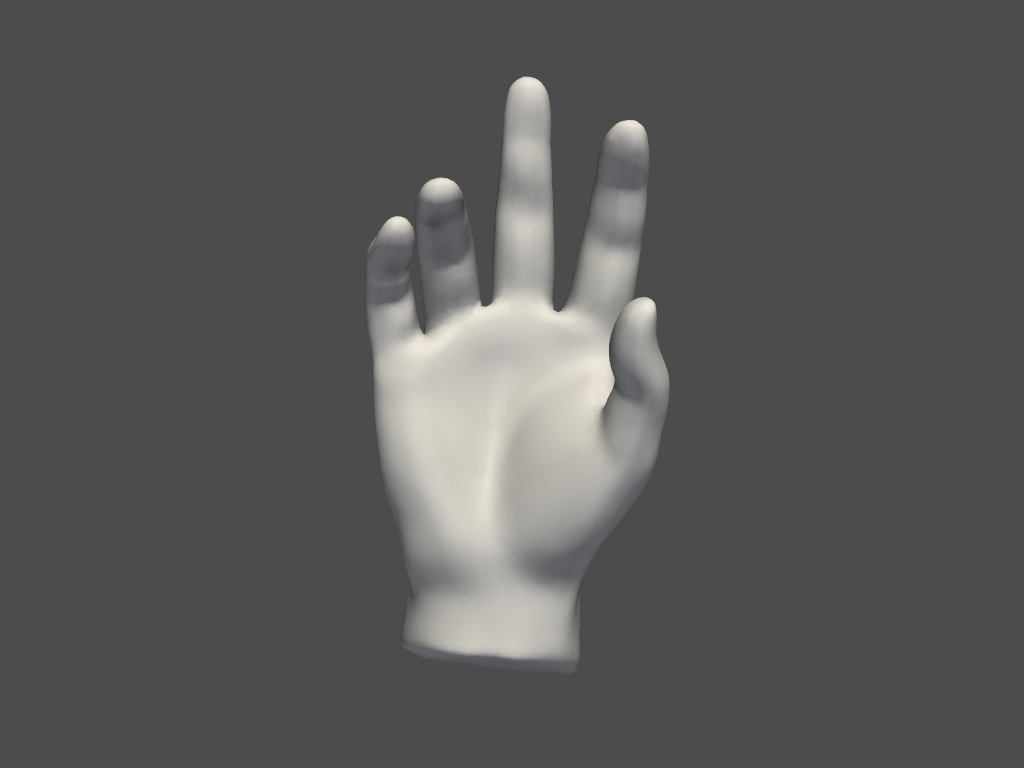

In [5]:
# show mean
pl = pv.Plotter(notebook=True)
pl.add_mesh(pv.PolyData(SSM.mean.v, meshes[0].faces), smooth_shading=True)
pl.view_yx()
pl.camera.roll += 180
pl.show(jupyter_backend='static')

Basic SSM properties can be accessed directly:
* `SSM.modes` its modes of variation,
* `SSM.variances` its per-mode-variances, and
* `SSM.coeffs` its shape coefficients (uniquely determining all input shapes)

Making straightforward use of the above one can generate samples from the SSM along the first mode of variation employing the exponential map of the underlying Shape Space:

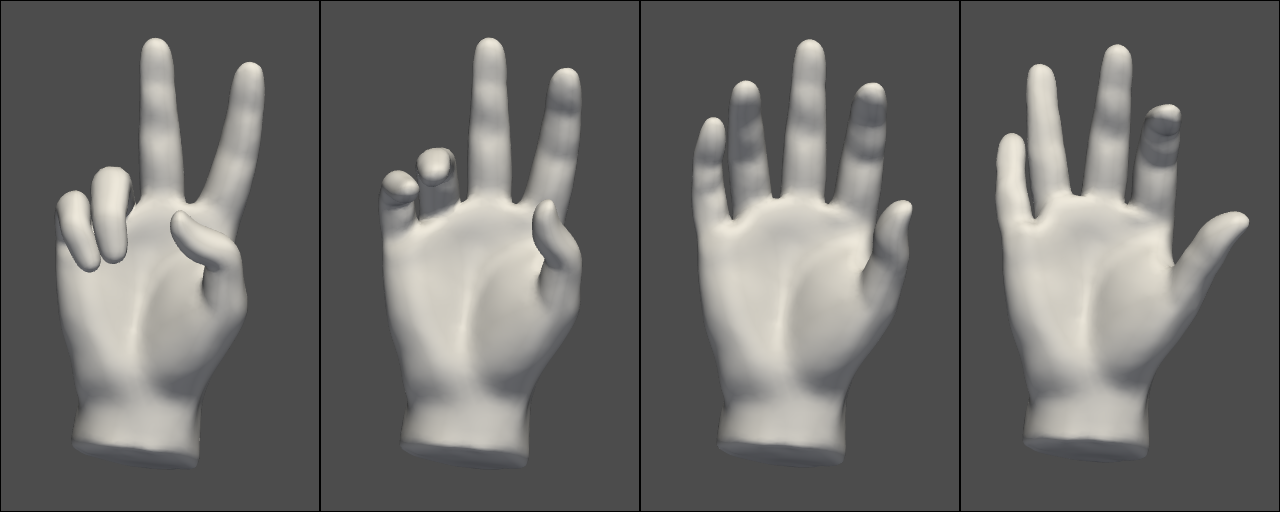

In [8]:
''' sample trajectory along the main mode of variation '''
import numpy as np

# standard deviation associated to 1st mode
std = np.sqrt(SSM.variances[0])

pl = pv.Plotter(notebook=True, shape=(1,4))
for i, t in enumerate(np.linspace(-1.0,1.0,4)):
    # excite mode
    coords = SSM.space.exp(SSM.mean_coords, t * std * SSM.modes[0])
    # map shape space coords to vertex coords
    v = SSM.space.from_coords(coords)
    # add mesh to plot
    pl.subplot(0, i)
    pl.add_mesh(pv.PolyData(v, meshes[0].faces), smooth_shading=True)
    pl.view_yx()
    pl.camera.roll += 180
    pl.camera.zoom(3)
pl.show(jupyter_backend='static', window_size=(1280,512))